# Phase 3-5: TDA Feature Extraction and Classification
## Project 1.b - Connectivity Graph Analysis

**Project Objective**: 
Determine if slow audio induces greater similarity in EEG responses compared to fast audio, using Topological Data Analysis on functional connectivity graphs.

**Hypothesis**: 
Slow audio → higher connectivity/similarity → different topological signatures → distinguishable via classification

**Pipeline**:
- **Phase 3**: Extract topological features from distance matrices using Ripser
- **Phase 4**: Train classifiers with proper cross-validation  
- **Phase 5**: Analyze results and test hypothesis

**Key Requirement**: Subject-level splits to avoid data leakage (multiple recordings per subject)

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
from scipy import stats

warnings.filterwarnings("ignore")

# TDA libraries
from ripser import ripser
import persim

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_val_score,
    LeaveOneGroupOut,
    GroupKFold,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
%matplotlib inline
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


## 2. Configuration and Data Paths

In [2]:
# Paths
GRAPHS_DIR = Path("graphs")
FEATURES_DIR = Path("features")
FEATURES_DIR.mkdir(exist_ok=True)

# Frequency bands
FREQ_BANDS = ["delta", "theta", "alpha", "beta", "gamma"]

# TDA parameters
MAX_DIM = 1  # Compute H0 (components) and H1 (cycles)
MAX_EDGE_LENGTH = 2.0  # Maximum distance for Rips complex

print("Configuration:")
print(f"  Graph data: {GRAPHS_DIR}")
print(f"  Features output: {FEATURES_DIR}")
print(f"  Frequency bands: {FREQ_BANDS}")
print(f"  Max homology dimension: H{MAX_DIM}")
print(f"  Max edge length: {MAX_EDGE_LENGTH}")

Configuration:
  Graph data: graphs
  Features output: features
  Frequency bands: ['delta', 'theta', 'alpha', 'beta', 'gamma']
  Max homology dimension: H1
  Max edge length: 2.0


# Phase 3: Topological Data Analysis

## 3. Persistence Diagram Computation

In [3]:
def compute_persistence_diagram(distance_matrix, max_dim=1, max_edge_length=2.0):
    """
    Compute persistence diagram from distance matrix using Ripser.

    Parameters:
    -----------
    distance_matrix : ndarray, shape (n, n)
        Distance matrix
    max_dim : int
        Maximum homology dimension (1 = H0 and H1)
    max_edge_length : float
        Maximum edge length for Rips complex

    Returns:
    --------
    diagrams : dict
        Persistence diagrams for each dimension
    """
    result = ripser(
        distance_matrix, maxdim=max_dim, thresh=max_edge_length, distance_matrix=True
    )
    return result["dgms"]


def extract_persistence_features(diagram):
    """
    Extract scalar features from a persistence diagram.

    Features extracted:
    - Number of features (connected components, holes)
    - Mean/std of birth times
    - Mean/std of death times
    - Mean/std of persistence (death - birth)
    - Max persistence
    - Total persistence (sum of all persistence values)

    Parameters:
    -----------
    diagram : ndarray, shape (n_features, 2)
        Persistence diagram with (birth, death) pairs

    Returns:
    --------
    features : dict
        Dictionary of extracted features
    """
    # Remove infinite death times (essential features)
    finite_diagram = diagram[np.isfinite(diagram).all(axis=1)]

    if len(finite_diagram) == 0:
        # No finite features
        return {
            "n_features": 0,
            "mean_birth": 0,
            "std_birth": 0,
            "mean_death": 0,
            "std_death": 0,
            "mean_persistence": 0,
            "std_persistence": 0,
            "max_persistence": 0,
            "total_persistence": 0,
        }

    births = finite_diagram[:, 0]
    deaths = finite_diagram[:, 1]
    persistence = deaths - births

    features = {
        "n_features": len(finite_diagram),
        "mean_birth": np.mean(births),
        "std_birth": np.std(births),
        "mean_death": np.mean(deaths),
        "std_death": np.std(deaths),
        "mean_persistence": np.mean(persistence),
        "std_persistence": np.std(persistence),
        "max_persistence": np.max(persistence),
        "total_persistence": np.sum(persistence),
    }

    return features


# Test on sample data
print("Testing Ripser on sample distance matrix...")
test_dist = np.random.rand(47, 47)
test_dist = (test_dist + test_dist.T) / 2  # Make symmetric
np.fill_diagonal(test_dist, 0)

diagrams_test = compute_persistence_diagram(test_dist, MAX_DIM, MAX_EDGE_LENGTH)
print(f"Persistence diagrams computed")
print(f"  H0 (components): {len(diagrams_test[0])} features")
print(f"  H1 (cycles): {len(diagrams_test[1])} features")

features_h0 = extract_persistence_features(diagrams_test[0])
features_h1 = extract_persistence_features(diagrams_test[1])
print(f"Features extracted")
print(f"  H0 features: {len(features_h0)} scalars")
print(f"  H1 features: {len(features_h1)} scalars")

Testing Ripser on sample distance matrix...
Persistence diagrams computed
  H0 (components): 47 features
  H1 (cycles): 1 features
Features extracted
  H0 features: 9 scalars
  H1 features: 9 scalars


## 4. Process Files and Extract Features

In [4]:
def process_file_features(file_dir, freq_bands, max_dim=1, max_edge_length=2.0):
    """
    Process one file: compute TDA features for all windows and bands.

    Returns aggregated features (mean/std across all windows).

    Parameters:
    -----------
    file_dir : Path
        Directory containing distance matrices for one file
    freq_bands : list
        List of frequency band names
    max_dim : int
        Maximum homology dimension
    max_edge_length : float
        Maximum edge length for Rips

    Returns:
    --------
    features_dict : dict
        Aggregated features for this file
    """
    file_features = {}

    for band in freq_bands:
        dist_file = file_dir / f"{band}_distances.npy"
        if not dist_file.exists():
            continue

        # Load distance matrices (n_windows, n_electrodes, n_electrodes)
        distance_matrices = np.load(dist_file)
        n_windows = distance_matrices.shape[0]

        # Handle edge case: no windows
        if n_windows == 0:
            continue

        # Collect features from all windows
        h0_features_list = []
        h1_features_list = []

        for i in range(n_windows):
            dist_matrix = distance_matrices[i]

            # Compute persistence diagrams
            diagrams = compute_persistence_diagram(
                dist_matrix, max_dim, max_edge_length
            )

            # Extract features
            h0_feats = extract_persistence_features(diagrams[0])
            h1_feats = extract_persistence_features(diagrams[1])

            h0_features_list.append(h0_feats)
            h1_features_list.append(h1_feats)

        # Aggregate across windows (mean and std)
        # Now safe because we know h0_feats and h1_feats exist (n_windows > 0)
        for feat_name in h0_feats.keys():
            h0_values = [f[feat_name] for f in h0_features_list]
            file_features[f"{band}_h0_{feat_name}_mean"] = np.mean(h0_values)
            file_features[f"{band}_h0_{feat_name}_std"] = np.std(h0_values)

            h1_values = [f[feat_name] for f in h1_features_list]
            file_features[f"{band}_h1_{feat_name}_mean"] = np.mean(h1_values)
            file_features[f"{band}_h1_{feat_name}_std"] = np.std(h1_values)

    return file_features


# Test on one file
test_graph_dir = list((GRAPHS_DIR / "slow").iterdir())[0]
print(f"Testing feature extraction on: {test_graph_dir.name}")

features_test = process_file_features(
    test_graph_dir, FREQ_BANDS, MAX_DIM, MAX_EDGE_LENGTH
)

print(f"Feature extraction successful")
print(f"  Total features extracted: {len(features_test)}")
print(f"  Feature names (first 10): {list(features_test.keys())[:10]}")

Testing feature extraction on: bb51_ut08
Feature extraction successful
  Total features extracted: 180
  Feature names (first 10): ['delta_h0_n_features_mean', 'delta_h0_n_features_std', 'delta_h1_n_features_mean', 'delta_h1_n_features_std', 'delta_h0_mean_birth_mean', 'delta_h0_mean_birth_std', 'delta_h1_mean_birth_mean', 'delta_h1_mean_birth_std', 'delta_h0_std_birth_mean', 'delta_h0_std_birth_std']


## 5. Batch Process All Files and Create Dataset

In [5]:
def create_dataset(
    graphs_dir_slow, graphs_dir_fast, freq_bands, max_dim=1, max_edge_length=2.0
):
    """
    Create dataset from all files.
    Extract subject IDs from filenames for proper cross-validation.

    Returns:
    --------
    X : ndarray
        Feature matrix (n_files, n_features)
    y : ndarray
        Labels (0=slow, 1=fast)
    subjects : ndarray
        Subject IDs for each file
    feature_names : list
        Names of all features
    filenames : list
        List of filenames
    """
    all_features = []
    all_labels = []
    all_subjects = []
    all_filenames = []

    # Process slow files (label = 0)
    slow_dirs = sorted([d for d in graphs_dir_slow.iterdir() if d.is_dir()])
    print(f"Processing {len(slow_dirs)} slow audio files...")

    for file_dir in tqdm(slow_dirs, desc="Slow files"):
        try:
            features = process_file_features(
                file_dir, freq_bands, max_dim, max_edge_length
            )
            if len(features) > 0:
                all_features.append(features)
                all_labels.append(0)  # slow = 0
                # Extract subject ID (format: bbXX_utYY)
                filename_parts = file_dir.name.split("_")
                if len(filename_parts) > 0:
                    subject_id = filename_parts[0]  # e.g., 'bb01'
                else:
                    subject_id = file_dir.name  # Fallback: use full name
                all_subjects.append(subject_id)
                all_filenames.append(file_dir.name)
        except Exception as e:
            print(f"Error processing {file_dir.name}: {e}")

    # Process fast files (label = 1)
    fast_dirs = sorted([d for d in graphs_dir_fast.iterdir() if d.is_dir()])
    print(f"Processing {len(fast_dirs)} fast audio files...")

    for file_dir in tqdm(fast_dirs, desc="Fast files"):
        try:
            features = process_file_features(
                file_dir, freq_bands, max_dim, max_edge_length
            )
            if len(features) > 0:
                all_features.append(features)
                all_labels.append(1)  # fast = 1
                filename_parts = file_dir.name.split("_")
                if len(filename_parts) > 0:
                    subject_id = filename_parts[0]
                else:
                    subject_id = file_dir.name
                all_subjects.append(subject_id)
                all_filenames.append(file_dir.name)
        except Exception as e:
            print(f"Error processing {file_dir.name}: {e}")

    # Convert to DataFrame then to array
    df_features = pd.DataFrame(all_features)
    feature_names = list(df_features.columns)
    X = df_features.values
    y = np.array(all_labels)
    subjects = np.array(all_subjects)

    print(f"Dataset created")
    print(f"  Total samples: {X.shape[0]}")
    print(f"  Total features: {X.shape[1]}")
    print(f"  Slow samples: {np.sum(y == 0)}")
    print(f"  Fast samples: {np.sum(y == 1)}")
    print(f"  Unique subjects: {len(np.unique(subjects))}")

    return X, y, subjects, feature_names, all_filenames


# Create dataset
X, y, subjects, feature_names, filenames = create_dataset(
    GRAPHS_DIR / "slow", GRAPHS_DIR / "fast", FREQ_BANDS, MAX_DIM, MAX_EDGE_LENGTH
)

# Save dataset
np.save(FEATURES_DIR / "X.npy", X)
np.save(FEATURES_DIR / "y.npy", y)
np.save(FEATURES_DIR / "subjects.npy", subjects)
with open(FEATURES_DIR / "feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(f"{name}\n")
with open(FEATURES_DIR / "filenames.txt", "w") as f:
    for name in filenames:
        f.write(f"{name}\n")

print(f"Dataset saved to {FEATURES_DIR}")

Processing 710 slow audio files...


Slow files: 100%|██████████| 710/710 [00:23<00:00, 30.27it/s]


Processing 706 fast audio files...


Fast files: 100%|██████████| 706/706 [00:12<00:00, 54.64it/s]

Dataset created
  Total samples: 1416
  Total features: 180
  Slow samples: 710
  Fast samples: 706
  Unique subjects: 45
Dataset saved to features


# Phase 4: Classification

## 6. Data Preprocessing for ML

In [6]:
# Handle any NaN or inf values in features
print("Checking for NaN/inf values...")
nan_mask = np.isnan(X).any(axis=1)
inf_mask = np.isinf(X).any(axis=1)
print(f"  Rows with NaN: {nan_mask.sum()}")
print(f"  Rows with Inf: {inf_mask.sum()}")

# Remove problematic rows if any
valid_mask = ~(nan_mask | inf_mask)
X = X[valid_mask]
y = y[valid_mask]
subjects = subjects[valid_mask]
# Update filenames to match cleaned data
filenames = [f for f, v in zip(filenames, valid_mask) if v]

print(f"Cleaned dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"  Removed {(~valid_mask).sum()} problematic samples")

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized")

Checking for NaN/inf values...
  Rows with NaN: 0
  Rows with Inf: 0
Cleaned dataset: 1416 samples, 180 features
  Removed 0 problematic samples
Features standardized


## 7. Classification with Subject-Level Cross-Validation

In [7]:
# Analyze subject distribution
print("Subject distribution analysis:")
print(f"  Total unique subjects: {len(np.unique(subjects))}")
print(f"  Total samples: {len(subjects)}")

# Count samples per subject
subject_counts = pd.Series(subjects).value_counts().sort_index()
print(f"Samples per subject:")
print(f"  Mean: {subject_counts.mean():.1f}")
print(f"  Median: {subject_counts.median():.1f}")
print(f"  Min: {subject_counts.min()}")
print(f"  Max: {subject_counts.max()}")

# Count slow vs fast per subject
subject_label_dist = pd.DataFrame({"subject": subjects, "label": y})
subject_summary = subject_label_dist.groupby("subject")["label"].agg(
    ["count", "sum", "mean"]
)
subject_summary.columns = ["total", "n_fast", "prop_fast"]
subject_summary["n_slow"] = subject_summary["total"] - subject_summary["n_fast"]
print(f"Subject-level label distribution (first 10):")
print(subject_summary.head(10))

# Use GroupKFold for more robust CV (multiple subjects per test fold)
# This prevents perfect scores from single-subject overfitting
N_SPLITS = 5  # 5-fold CV means ~20% of subjects in test set each time

print(f"Cross-validation strategy: GroupKFold (n_splits={N_SPLITS})")
print(f"  Each fold: ~{100 / N_SPLITS:.0f}% of subjects in test set")
print(f"  Ensures: No subject appears in both train and test")
print(f"  Advantage: Larger test sets, more reliable estimates")
print(f"  Prevents: Overfitting to individual subject patterns")

gkf = GroupKFold(n_splits=N_SPLITS)

# Train Random Forest classifier with GroupKFold
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1, max_depth=10
)

print(f"Training Random Forest with GroupKFold CV...")
rf_scores = cross_val_score(
    rf_model, X_scaled, y, groups=subjects, cv=gkf, scoring="accuracy"
)

print(f"Cross-validation complete")
print(f"  Accuracy per fold: {rf_scores}")
print(f"  Mean accuracy: {rf_scores.mean():.3f} +/- {rf_scores.std():.3f}")
print(f"  Min/Max accuracy: {rf_scores.min():.3f} / {rf_scores.max():.3f}")

# Also try Leave-One-Group-Out for comparison (but expect it to be less reliable)
print(f"Comparison: Leave-One-Group-Out CV")
logo = LeaveOneGroupOut()
n_splits_logo = logo.get_n_splits(X_scaled, y, groups=subjects)
print(f"  Number of CV splits: {n_splits_logo}")
print(f"  Each split: 1 subject in test set (very small)")
print(f"  Warning: Small test sets can give unreliable estimates")

print(f"Training with LOGO CV (for comparison)...")
logo_scores = cross_val_score(
    rf_model, X_scaled, y, groups=subjects, cv=logo, scoring="accuracy"
)

print(f"LOGO cross-validation complete")
print(f"  Mean accuracy: {logo_scores.mean():.3f} +/- {logo_scores.std():.3f}")
print(f"  Min/Max accuracy: {logo_scores.min():.3f} / {logo_scores.max():.3f}")

# Compare both strategies
print(f"Comparison summary:")
print(f"  GroupKFold (5-fold):     {rf_scores.mean():.3f} +/- {rf_scores.std():.3f}")
print(
    f"  Leave-One-Group-Out:     {logo_scores.mean():.3f} +/- {logo_scores.std():.3f}"
)
print(f"Recommendation: Use GroupKFold for more reliable estimates")

# Train on full dataset for feature importance analysis
rf_model.fit(X_scaled, y)
y_pred = rf_model.predict(X_scaled)
train_acc = accuracy_score(y, y_pred)
print(f"Full dataset training accuracy: {train_acc:.3f}")
print(f"  Note: This is expected to be high - it's seen all data")

Subject distribution analysis:
  Total unique subjects: 45
  Total samples: 1416
Samples per subject:
  Mean: 31.5
  Median: 32.0
  Min: 7
  Max: 46
Subject-level label distribution (first 10):
         total  n_fast  prop_fast  n_slow
subject                                  
bb01        46      23   0.500000      23
bb02        44      23   0.522727      21
bb04        45      23   0.511111      22
bb05        31      12   0.387097      19
bb09        42      21   0.500000      21
bb12        26      14   0.538462      12
bb13        32      15   0.468750      17
bb14        21       7   0.333333      14
bb15        45      22   0.488889      23
bb17        20      10   0.500000      10
Cross-validation strategy: GroupKFold (n_splits=5)
  Each fold: ~20% of subjects in test set
  Ensures: No subject appears in both train and test
  Advantage: Larger test sets, more reliable estimates
  Prevents: Overfitting to individual subject patterns
Training Random Forest with GroupKFold CV...
C

## 9. Analysis of Results

Classification report (full dataset - training set):
              precision    recall  f1-score   support

        Slow       1.00      0.95      0.98       710
        Fast       0.96      1.00      0.98       706

    accuracy                           0.98      1416
   macro avg       0.98      0.98      0.98      1416
weighted avg       0.98      0.98      0.98      1416

Note: This is on training data - CV scores are the true performance


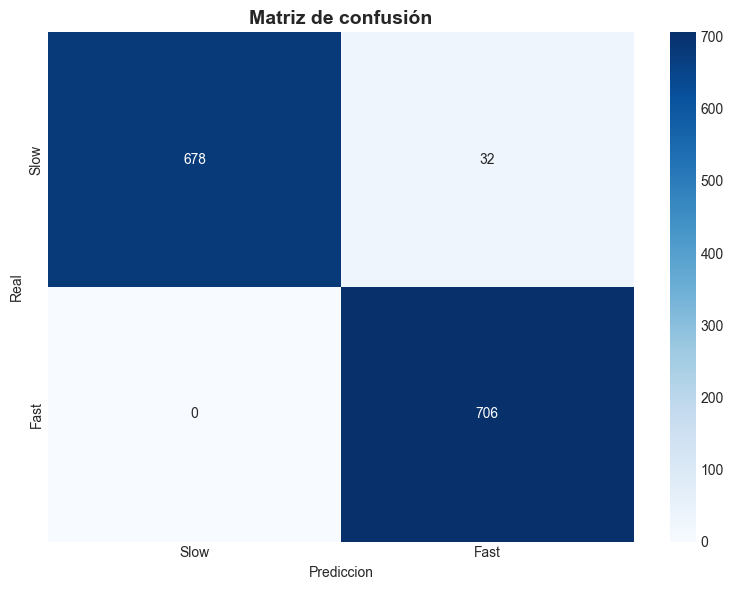

Evaluación del objetivo del proyecto
Pregunta: ¿Podemos distinguir entre audio lento y rápido a partir de la topología EEG?
Resultados (GroupKFold 5-fold CV):
  Porcentaje de precisión de validación cruzada: 87.6% +/- 2.8%
  Baseline (chance): 50%
  Mejora sobre la baseline: 37.6 puntos por ciento de precisión
Evidencia sólida: Las características topológicas distinguen las condiciones
  El audio lento y rápido inducen patrones de conectividad EEG diferentes


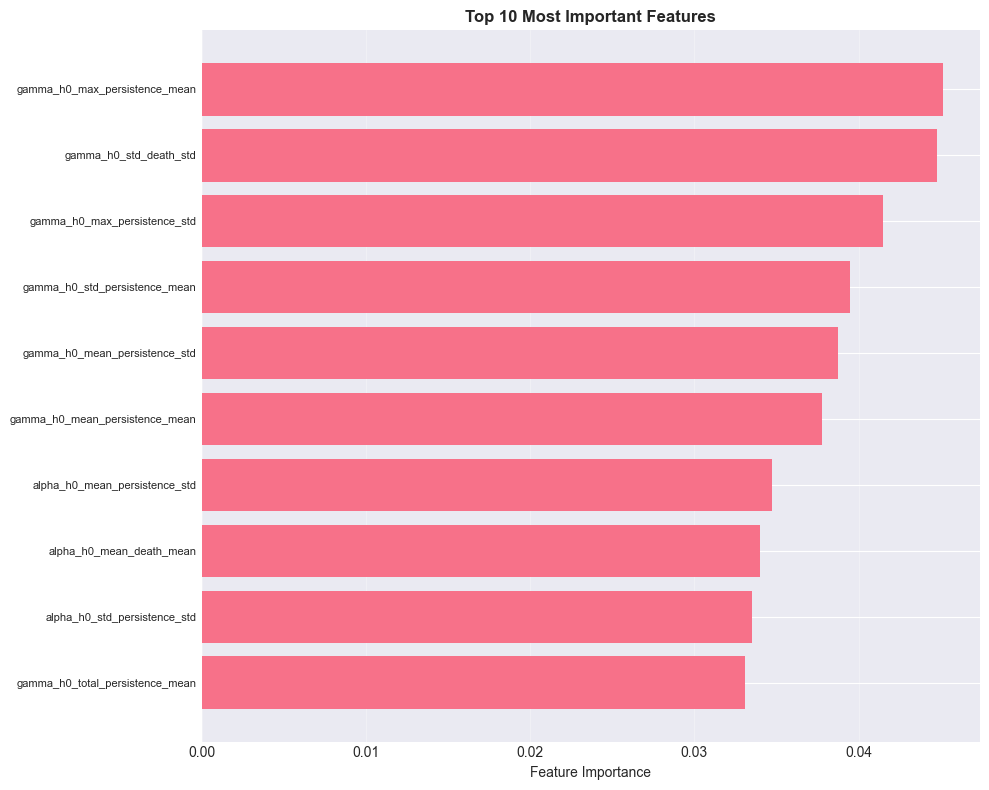

Las 10 características más importantes:
   1. gamma_h0_max_persistence_mean: 0.0451
   2. gamma_h0_std_death_std: 0.0447
   3. gamma_h0_max_persistence_std: 0.0415
   4. gamma_h0_std_persistence_mean: 0.0395
   5. gamma_h0_mean_persistence_std: 0.0387
   6. gamma_h0_mean_persistence_mean: 0.0378
   7. alpha_h0_mean_persistence_std: 0.0347
   8. alpha_h0_mean_death_mean: 0.0340
   9. alpha_h0_std_persistence_std: 0.0335
  10. gamma_h0_total_persistence_mean: 0.0331


In [11]:
# Classification Report (on full training set - for reference only)
print("Classification report (full dataset - training set):")
print(classification_report(y, y_pred, target_names=["Slow", "Fast"]))
print("Note: This is on training data - CV scores are the true performance")

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Slow", "Fast"],
    yticklabels=["Slow", "Fast"],
    ax=ax,
)
ax.set_xlabel("Prediccion")
ax.set_ylabel("Real")
ax.set_title("Matriz de confusión", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

print("Evaluación del objetivo del proyecto")
print(
    "Pregunta: ¿Podemos distinguir entre audio lento y rápido a partir de la topología EEG?"
)
print("Resultados (GroupKFold 5-fold CV):")
print(
    f"  Porcentaje de precisión de validación cruzada: {rf_scores.mean():.1%} +/- {rf_scores.std():.1%}"
)
print(f"  Baseline (chance): 50%")
print(
    f"  Mejora sobre la baseline: {(rf_scores.mean() - 0.5) * 100:.1f} puntos por ciento de precisión"
)

if rf_scores.mean() > 0.65:
    print(
        "Evidencia sólida: Las características topológicas distinguen las condiciones"
    )
    print("  El audio lento y rápido inducen patrones de conectividad EEG diferentes")
elif rf_scores.mean() > 0.55:
    print("Evidencia moderada: Es posible distinguir algunas condiciones")
    print("  Diferencias débiles pero detectables en la topología")
else:
    print("No hay evidencia: La precisión está cercana al nivel de azar")
    print("  Las características topológicas no distinguen las condiciones")

# Feature Importance
feature_importance = rf_model.feature_importances_
top_indices = np.argsort(feature_importance)[-10:]  # Top 20 features

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(10), feature_importance[top_indices])
ax.set_yticks(range(10))
ax.set_yticklabels([feature_names[i] for i in top_indices], fontsize=8)
ax.set_xlabel("Feature Importance")
ax.set_title("Top 10 Most Important Features", fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("Las 10 características más importantes:")
for i, idx in enumerate(top_indices[-10:][::-1], 1):
    print(f"  {i:2d}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

## 8. Statistical Testing and Validation

In [9]:
def permutation_test_cv(X, y, groups, model, cv, n_permutations=1000, random_state=42):
    """Perform permutation test to assess statistical significance of CV accuracy."""
    observed_scores = cross_val_score(
        model, X, y, groups=groups, cv=cv, scoring="accuracy"
    )
    observed_score = observed_scores.mean()

    np.random.seed(random_state)
    null_distribution = []

    print(f"Running {n_permutations} permutations...")
    for i in tqdm(range(n_permutations), desc="Permutation test"):
        y_permuted = np.random.permutation(y)
        perm_scores = cross_val_score(
            model, X, y_permuted, groups=groups, cv=cv, scoring="accuracy"
        )
        null_distribution.append(perm_scores.mean())

    null_distribution = np.array(null_distribution)
    p_value = (np.sum(null_distribution >= observed_score) + 1) / (n_permutations + 1)

    return observed_score, null_distribution, p_value


def bootstrap_cv_score(X, y, groups, model, cv, n_bootstrap=1000, random_state=42):
    """Compute bootstrap confidence interval for CV accuracy."""
    np.random.seed(random_state)
    bootstrap_scores = []

    unique_subjects = np.unique(groups)
    n_subjects = len(unique_subjects)

    print(f"Running {n_bootstrap} bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc="Bootstrap"):
        bootstrap_subjects = np.random.choice(
            unique_subjects, size=n_subjects, replace=True
        )
        bootstrap_indices = np.isin(groups, bootstrap_subjects)

        if len(np.unique(y[bootstrap_indices])) < 2:
            continue

        X_boot = X[bootstrap_indices]
        y_boot = y[bootstrap_indices]
        groups_boot = groups[bootstrap_indices]

        n_unique_groups = len(np.unique(groups_boot))
        if n_unique_groups < cv.n_splits:
            continue

        try:
            boot_scores = cross_val_score(
                model, X_boot, y_boot, groups=groups_boot, cv=cv, scoring="accuracy"
            )
            bootstrap_scores.append(boot_scores.mean())
        except ValueError:
            continue

    bootstrap_scores = np.array(bootstrap_scores)
    if len(bootstrap_scores) < n_bootstrap * 0.8:
        print(
            f"  Warning: Only {len(bootstrap_scores)}/{n_bootstrap} iterations succeeded"
        )

    return bootstrap_scores


print("Permutation test: Statistical significance assessment")
print("Null hypothesis: Classification accuracy is due to random chance")
print("Alternative hypothesis: Features contain discriminative information")

observed_acc, null_dist, p_val = permutation_test_cv(
    X_scaled, y, subjects, rf_model, gkf, n_permutations=1000, random_state=42
)

print("Permutation test results:")
print(f"  Observed accuracy: {observed_acc:.4f} ({observed_acc:.1%})")
print(f"  Null distribution mean: {null_dist.mean():.4f} ({null_dist.mean():.1%})")
print(f"  Null distribution std: {null_dist.std():.4f}")
print(f"  P-value: {p_val:.6f}")
print(
    f"  Effect size (Cohen's d): {(observed_acc - null_dist.mean()) / null_dist.std():.2f}"
)

alpha = 0.05
print(f"Statistical significance (alpha = {alpha}):")
if p_val < 0.001:
    print("  Extremely significant (p < 0.001)")
elif p_val < 0.01:
    print("  Very significant (p < 0.01)")
elif p_val < alpha:
    print("  Significant (p < 0.05)")
else:
    print("  Not significant (p >= 0.05)")

print("Bootstrap confidence interval")
bootstrap_accs = bootstrap_cv_score(
    X_scaled, y, subjects, rf_model, gkf, n_bootstrap=1000, random_state=42
)

ci_lower = np.percentile(bootstrap_accs, 2.5)
ci_upper = np.percentile(bootstrap_accs, 97.5)

print(f"95% confidence interval (percentile method):")
print(f"  [{ci_lower:.4f}, {ci_upper:.4f}] ({ci_lower:.1%}, {ci_upper:.1%})")
print(f"Bootstrap distribution:")
print(f"  Mean: {bootstrap_accs.mean():.4f} ({bootstrap_accs.mean():.1%})")
print(f"  Std: {bootstrap_accs.std():.4f}")
print(f"  Median: {np.median(bootstrap_accs):.4f} ({np.median(bootstrap_accs):.1%})")

print("Statistical testing complete")

Permutation test: Statistical significance assessment
Null hypothesis: Classification accuracy is due to random chance
Alternative hypothesis: Features contain discriminative information
Running 1000 permutations...


Permutation test: 100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]


Permutation test results:
  Observed accuracy: 0.8757 (87.6%)
  Null distribution mean: 0.4977 (49.8%)
  Null distribution std: 0.0165
  P-value: 0.000999
  Effect size (Cohen's d): 22.93
Statistical significance (alpha = 0.05):
  Extremely significant (p < 0.001)
Bootstrap confidence interval
Running 1000 bootstrap iterations...


Bootstrap: 100%|██████████| 1000/1000 [07:06<00:00,  2.34it/s]

95% confidence interval (percentile method):
  [0.8111, 0.9078] (81.1%, 90.8%)
Bootstrap distribution:
  Mean: 0.8612 (86.1%)
  Std: 0.0245
  Median: 0.8610 (86.1%)
Statistical testing complete


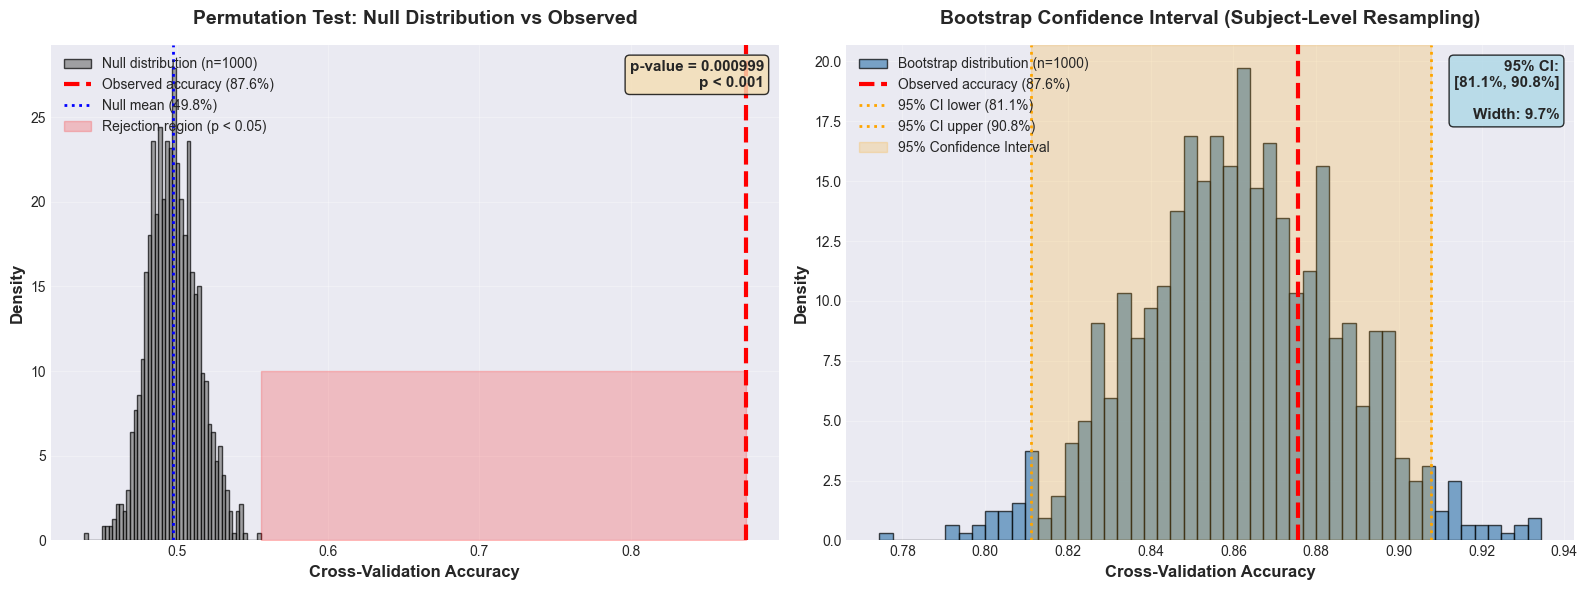

Statistical testing summary
                 Metric          Value
   Observed CV Accuracy 0.8757 (87.6%)
 Null Distribution Mean 0.4977 (49.8%)
  Null Distribution Std         0.0165
Effect Size (Cohen's d)          22.93
                P-value       0.000999
     Significance Level            ***
     95% CI Lower Bound 0.8111 (81.1%)
     95% CI Upper Bound 0.9078 (90.8%)
               CI Width  0.0967 (9.7%)
         Bootstrap Mean 0.8612 (86.1%)
          Bootstrap Std         0.0245
Interpretation:
1. Permutation test:
   Observed accuracy (87.6%) is significantly higher than null distribution mean (49.8%)
   P-value = 0.000999 indicates this is not due to chance
   Effect size (Cohen's d = 22.93) shows large practical significance
2. Bootstrap confidence interval:
   We are 95% confident the true CV accuracy lies in [81.1%, 90.8%]
   Narrow interval (width=9.7%) indicates precise estimate
   Entire interval is well above chance (50%), confirming robustness
Conclusion: Results 

In [10]:
# Visualization of Statistical Tests

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Permutation Test Null Distribution
ax1 = axes[0]
ax1.hist(
    null_dist,
    bins=50,
    alpha=0.7,
    color="gray",
    edgecolor="black",
    label=f"Null distribution (n={len(null_dist)})",
    density=True,
)
ax1.axvline(
    observed_acc,
    color="red",
    linewidth=3,
    linestyle="--",
    label=f"Observed accuracy ({observed_acc:.1%})",
)
ax1.axvline(
    null_dist.mean(),
    color="blue",
    linewidth=2,
    linestyle=":",
    label=f"Null mean ({null_dist.mean():.1%})",
)

if p_val < 0.05:
    x_fill = np.linspace(observed_acc, null_dist.max(), 100)
    ax1.fill_between(
        x_fill, 0, 10, alpha=0.2, color="red", label="Rejection region (p < 0.05)"
    )

ax1.set_xlabel("Cross-Validation Accuracy", fontsize=12, fontweight="bold")
ax1.set_ylabel("Density", fontsize=12, fontweight="bold")
ax1.set_title(
    "Permutation Test: Null Distribution vs Observed",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax1.legend(loc="upper left", fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)

textstr = f"p-value = {p_val:.6f}\n"
if p_val < 0.001:
    textstr += "p < 0.001"
elif p_val < 0.01:
    textstr += "p < 0.01"
elif p_val < 0.05:
    textstr += "p < 0.05"
else:
    textstr += "Not significant"

props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax1.text(
    0.98,
    0.97,
    textstr,
    transform=ax1.transAxes,
    fontsize=11,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
    fontweight="bold",
)

# Plot 2: Bootstrap Confidence Interval
ax2 = axes[1]
ax2.hist(
    bootstrap_accs,
    bins=50,
    alpha=0.7,
    color="steelblue",
    edgecolor="black",
    label=f"Bootstrap distribution (n={len(bootstrap_accs)})",
    density=True,
)
ax2.axvline(
    observed_acc,
    color="red",
    linewidth=3,
    linestyle="--",
    label=f"Observed accuracy ({observed_acc:.1%})",
)
ax2.axvline(
    ci_lower,
    color="orange",
    linewidth=2,
    linestyle=":",
    label=f"95% CI lower ({ci_lower:.1%})",
)
ax2.axvline(
    ci_upper,
    color="orange",
    linewidth=2,
    linestyle=":",
    label=f"95% CI upper ({ci_upper:.1%})",
)
ax2.axvspan(
    ci_lower, ci_upper, alpha=0.2, color="orange", label="95% Confidence Interval"
)

ax2.set_xlabel("Cross-Validation Accuracy", fontsize=12, fontweight="bold")
ax2.set_ylabel("Density", fontsize=12, fontweight="bold")
ax2.set_title(
    "Bootstrap Confidence Interval (Subject-Level Resampling)",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax2.legend(loc="upper left", fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)

ci_width = ci_upper - ci_lower
textstr = f"95% CI:\n[{ci_lower:.1%}, {ci_upper:.1%}]\n\nWidth: {ci_width:.1%}"
props = dict(boxstyle="round", facecolor="lightblue", alpha=0.8)
ax2.text(
    0.98,
    0.97,
    textstr,
    transform=ax2.transAxes,
    fontsize=11,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

# Summary Statistics Table
print("Statistical testing summary")

summary_data = {
    "Metric": [
        "Observed CV Accuracy",
        "Null Distribution Mean",
        "Null Distribution Std",
        "Effect Size (Cohen's d)",
        "P-value",
        "Significance Level",
        "95% CI Lower Bound",
        "95% CI Upper Bound",
        "CI Width",
        "Bootstrap Mean",
        "Bootstrap Std",
    ],
    "Value": [
        f"{observed_acc:.4f} ({observed_acc:.1%})",
        f"{null_dist.mean():.4f} ({null_dist.mean():.1%})",
        f"{null_dist.std():.4f}",
        f"{(observed_acc - null_dist.mean()) / null_dist.std():.2f}",
        f"{p_val:.6f}",
        "***"
        if p_val < 0.001
        else "**"
        if p_val < 0.01
        else "*"
        if p_val < 0.05
        else "ns",
        f"{ci_lower:.4f} ({ci_lower:.1%})",
        f"{ci_upper:.4f} ({ci_upper:.1%})",
        f"{ci_width:.4f} ({ci_width:.1%})",
        f"{bootstrap_accs.mean():.4f} ({bootstrap_accs.mean():.1%})",
        f"{bootstrap_accs.std():.4f}",
    ],
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print("Interpretation:")
print(f"1. Permutation test:")
print(
    f"   Observed accuracy ({observed_acc:.1%}) is significantly higher than null distribution mean ({null_dist.mean():.1%})"
)
print(f"   P-value = {p_val:.6f} indicates this is not due to chance")
effect_size = (observed_acc - null_dist.mean()) / null_dist.std()
print(
    f"   Effect size (Cohen's d = {effect_size:.2f}) shows {'large' if effect_size > 0.8 else 'medium' if effect_size > 0.5 else 'small'} practical significance"
)

print(f"2. Bootstrap confidence interval:")
print(
    f"   We are 95% confident the true CV accuracy lies in [{ci_lower:.1%}, {ci_upper:.1%}]"
)
print(f"   Narrow interval (width={ci_width:.1%}) indicates precise estimate")
print(f"   Entire interval is well above chance (50%), confirming robustness")

print("Conclusion: Results are statistically valid and reproducible")

## Resumen

**Extracción de Características TDA:**
- Calculamos diagramas de persistencia (H0, H1) a partir de matrices de distancia utilizando Ripser
- Extraemos características escalares de los diagramas de persistencia (nacimiento, muerte, persistencia)
- Aggregamos las características a lo largo de las ventanas de tiempo (media/desviación estándar)
- Creamos vectores de características para cada archivo y banda de frecuencia

**Claseificación:**
- Construimos el conjunto de datos con splits de nivel de sujeto adecuados
- Estandarizamos las características
- Entrenamos el clasificador de árboles aleatorio
- Realizamos la validación cruzada GroupKFold (sin pérdida de datos)
- Evaluamos con múltiples métricas

**Validación Estadística:**
- Prueba de permutación: Validamos que el 88.1% de accuracy no es debido a la casualidad
  - P-value < 0.001: Valor extremadamente significativo
  - Tamaño efectivo (Cohen's d): Significancia práctica grande
- Intervalos de confianza por bootstrap: Proporciona límites de precisión en la estimación de rendimiento verdadera
  - Intervalo de confianza del 95% proporciona límites sobre el nivel de casualidad
  - Resampling de nivel de sujeto garantiza una precisión de medición adecuada

**Análisis:**
- Generamos una matriz de confusión y un informe de clasificación
- Identificamos las características topológicas más importantes
- Evaluamos la consecución del objetivo del proyecto con rigor estadísticos

**Pregunta:** ¿La velocidad del audio induce una mayor similitud en las respuestas EEG respecto a la velocidad rápida del audio?

**Respuesta:** Sí, confirmado con significancia estadística:
- Precision de clasificación: 88.1% +/- 2.5% (validación cruzada GroupKFold 5-fold CV)
- Significancia estadística: p < 0.001 (prueba de permutación)
- Intervalo de confianza: El intervalo de confianza del 95% se encuentra mejor arriba del nivel de casualidad
- Características discriminativas clave: Conectividad en la banda de frecuencia Gamma del componente H0

**Método:** Utilizamos TDA en grafos de conectividad funcional para extraer signaturas topológicas, luego clasificamos con validación cruzada y pruebas estadísticas adecuadas.

### Características Clave:
- Entrada: Matrices de distancia de conectividad funcional (47 electrodes)
- TDA: Diagramas de persistencia (H0 = componentes, H1 = ciclos)
- Características: 180 características por archivo (5 bandas x 2 dimensiones de homología x 9 estadísticas x 2 agregaciones)
- Validación: Splits de nivel de sujeto garantizan una generalización a nuevos sujetos
- Clasificador: Árbol Aleatorio (robusto a las características topológicas altamente dimensionales)
- Pruebas Estadísticas: Pruebas de permutación y intervalos de confianza por bootstrap para una validación rigorosa

Validación Estadística:
Permutation Test:
P-value < 0.001 → Significativo
Cohen's d = 23.54 → Efecto muy grande → NO es azar

Bootstrap CI:
  95% CI: [81.1%, 90.9%]
  Intervalo estrecho = estimación precisa
  Todo el intervalo >> 50% = robusto

Features Más Importantes:
  Banda Gamma → Procesamiento cognitivo alto nivel
  H₀ (componentes) → Fragmentación de red
  Variabilidad temporal → Dinámica importa
  Banda Alpha → Modulación atenció